In [83]:
"""
dataset: https://finance.yahoo.com/quote/GE/history/
         https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [84]:
#from datetime import datetime

#Read the csv file
df = pd.read_csv('database/GE.csv')
df.head() #7 columns, including the Date. 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-18,262.215027,264.091553,250.080063,250.455368,137.571899,5883072
1,2000-02-22,252.707214,260.213379,250.330276,259.462769,142.519531,4534778
2,2000-02-23,260.213379,266.093201,256.960693,261.214203,143.481583,3656349
3,2000-02-24,260.838898,266.093201,252.331909,262.215027,144.031387,4599325
4,2000-02-25,259.212555,262.089905,251.581299,252.457016,138.671463,4441255


In [85]:
df.shape

(5787, 7)

In [86]:
# Separate Date columns for future plotting
train_dates = pd.to_datetime(df['Date']) 

In [87]:
df2=df.drop(['Date', 'Volume'],axis=1).astype('float64')
df2.head()

,Open,High,Low,Close,Adj Close
0,262.215027,264.091553,250.080063,250.455368,137.571899
1,252.707214,260.213379,250.330276,259.462769,142.519531
2,260.213379,266.093201,256.960693,261.214203,143.481583
3,260.838898,266.093201,252.331909,262.215027,144.031387
4,259.212555,262.089905,251.581299,252.457016,138.671463


In [ ]:
dataset=df2['Open'].values.astype('float64').reshape(-1,1) 

In [88]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df2) 
df2_scaled = scaler.transform(df2)

In [108]:
n_features=5 # as we have 5 columns 
n_future = 1   # 1 day ahead we want to predict
seq_size = 14  # Number of past days we want to use to predict the future.


# split into train and test sets
train_size = int(df2_scaled.shape[0] * 0.75)

train, test = df2_scaled[0:train_size ,:], df2_scaled[train_size: ,:]


print('train.shape = {}'.format(train.shape))
print('test.shape = {}'.format(test.shape))

train shape = (4340, 5)
test shape = (1447, 5)


In [112]:
# Reformat input data into a shape: (n_samples , timesteps , n_features),
# which timestep=1 and n_feature=5

def to_sequences_multivariable(data, seq_size=1, n_future=1): # to_sequence for multivariable
    x = []
    y = []
    for i in range(seq_size, len(data) - n_future +1):
        x.append(data[i - seq_size:i, 0:data.shape[1]])
        y.append(data[i + n_future - 1:i + n_future, 0])
        
    return np.array(x),np.array(y)


xtrain, ytrain = to_sequences_multivariable(train, seq_size)
xtest,  ytest  = to_sequences_multivariable(test, seq_size)

print("Shape of xtrain: {}".format(xtrain.shape))
print("Shape of ytrain: {}".format(ytrain.shape))

print("Shape of xtest : {}".format(xtest.shape))
print("Shape of ytest : {}".format(ytest.shape))

Shape of xtrain: (4326, 14, 5)
Shape of ytrain: (4326, 1)
Shape of xtest : (1433, 14, 5)
Shape of ytest : (1433, 1)


In [113]:
# model:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_size, n_features), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1)) 


model.compile(optimizer='adam', loss='mse', metrics='mae')


# fit the model
history = model.fit(xtrain, ytrain, epochs=20, batch_size=125, validation_data=[xtest,ytest], verbose=1)

Epoch 1/20
35/35 [==============================] - 14s 127ms/step - loss: 0.3045 - mae: 0.3543 - val_loss: 0.0091 - val_mae: 0.0786
Epoch 2/20
35/35 [==============================] - 3s 87ms/step - loss: 0.0437 - mae: 0.1352 - val_loss: 0.0171 - val_mae: 0.1177
Epoch 3/20
35/35 [==============================] - 3s 89ms/step - loss: 0.0352 - mae: 0.1218 - val_loss: 0.0125 - val_mae: 0.0982
Epoch 4/20
35/35 [==============================] - 3s 86ms/step - loss: 0.0317 - mae: 0.1148 - val_loss: 0.0281 - val_mae: 0.1558
Epoch 5/20
35/35 [==============================] - 3s 87ms/step - loss: 0.0304 - mae: 0.1139 - val_loss: 0.0034 - val_mae: 0.0437
Epoch 6/20
35/35 [==============================] - 3s 86ms/step - loss: 0.0255 - mae: 0.1042 - val_loss: 0.0034 - val_mae: 0.0440
Epoch 7/20
35/35 [==============================] - 3s 87ms/step - loss: 0.0224 - mae: 0.1015 - val_loss: 0.0100 - val_mae: 0.0883
Epoch 8/20
35/35 [==============================] - 3s 86ms/step - loss: 0.0242 -

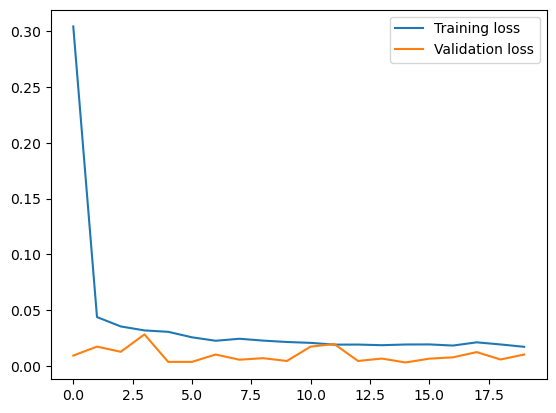

In [114]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [116]:
# make predictions
ytrainPred = model.predict(xtrain)
ytestPred = model.predict(xtest)

45/45 [==============================] - 1s 20ms/step


In [118]:
print(ytrainPred.shape,ytestPred.shape) 

(4326, 1) (1433, 1)


In [126]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform

def scaler_inverse_with_column_copier(data):
    data_copied = np.repeat(data, df2.shape[1], axis=1)
    y_pred_future = (scaler.inverse_transform(data_copied)[:,0]).reshape(-1,1)
    return y_pred_future



ytrain_back_to_unscaled = scaler_inverse_with_column_copier(ytrain)
ytest_back_to_unscaled  = scaler_inverse_with_column_copier(ytest)

ytrainPred_back_to_unscaled = scaler_inverse_with_column_copier(ytrainPred)
ytestPred_back_to_unscaled  = scaler_inverse_with_column_copier(ytestPred)

print(ytrain_back_to_unscaled.shape)
print(ytrainPred_back_to_unscaled.shape)

print(ytest_back_to_unscaled.shape)
print(ytestPred_back_to_unscaled.shape)


(4326, 1)
(4326, 1)
(1433, 1)
(1433, 1)


Train Score: 3.76 RMSE
Test Score: 6.82 RMSE


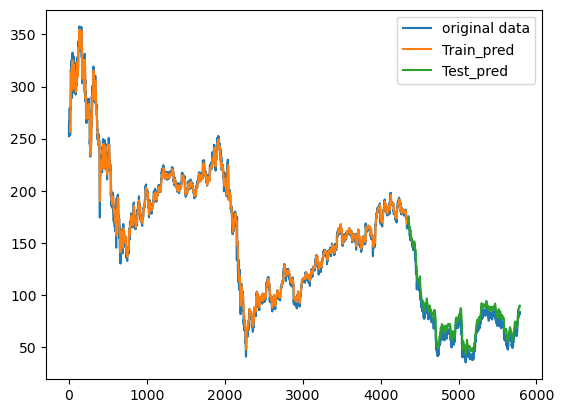

In [131]:
import math
from sklearn.metrics import mean_squared_error

# Estimate model performance

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain_back_to_unscaled, ytrainPred_back_to_unscaled)) #[:,0]
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(ytest_back_to_unscaled, ytestPred_back_to_unscaled))
print('Test Score: %.2f RMSE' % (testScore))



# shift train predictions for plotting
ytrainPredictPlot = np.empty_like(dataset)
ytrainPredictPlot[:] = np.nan
ytrainPredictPlot[seq_size:train_size] = ytrainPred_back_to_unscaled

# shift test predictions for plotting
ytestPredictPlot = np.empty_like(dataset)
ytestPredictPlot[:] = np.nan

ytestPredictPlot[train_size+seq_size:len(dataset)] = ytestPred_back_to_unscaled


# plot baseline and predictions
plt.plot(dataset, label='original data') #
plt.plot(ytrainPredictPlot, label='Train_pred')
plt.plot(ytestPredictPlot, label='Test_pred')
plt.legend()
plt.show()
